In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
from pandas import read_csv
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
%matplotlib inline

train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/item_categories.csv')
submission = pd.read_csv('sample_submission.csv')
train.describe()

FileNotFoundError: File b'dataset/sales_train.csv' does not exist

In [6]:
from datetime import datetime

#find missing date
def datekey(item):
    date, _ = item
    #print(date)
    d, m, y = date.split('.')
    #print(y+m+d)
    return y+m+d

def getdatelist(beginDate, endDate):
    date_l=[datetime.strftime(x,'%d.%m.%Y') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

datelist = Counter(train['date'])
datelist = sorted(datelist.items(), key=datekey)
print(len(datelist))
#01.01.2013 - 31.10.2015

fulldatelist = getdatelist('20130101', '20151031')
print(len(fulldatelist))

1034
1034


Counter({1.0: 2163, 2.0: 136, 3.0: 20, -1.0: 3, 4.0: 2, 17.0: 1})
item_id: 2574


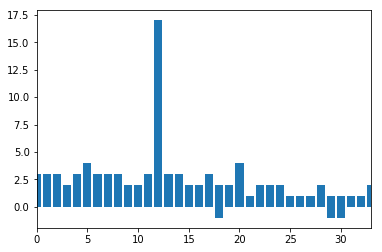

In [7]:
#sale month
def bar_sale_item(data, itemid):
    selected_data = data[data.item_id==itemid]
    selected_item_cnt_day = selected_data['item_cnt_day']
    print(Counter(selected_item_cnt_day))
    print("item_id:",itemid)
    plt.xlim((0,33))
    plt.bar(selected_data['date_block_num'], selected_data['item_cnt_day'])
    return

#Counter(train['date_block_num']) #34months
bar_sale_item(train, 2574)

1562733.0
1320889.0
764584.0


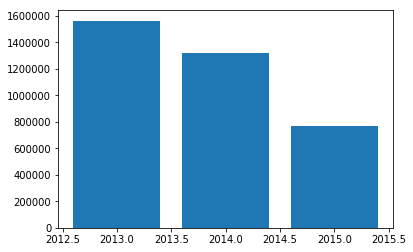

In [8]:
def bar_sale_year(data):
    data['year'] = data['date'].str.split('.').str[2]
    total_sale = []
    for i in range(2013, 2016):
        selected_data = data[data.year==str(i)]
        print(sum(selected_data['item_cnt_day']))
        total_sale.append(sum(selected_data['item_cnt_day']))
    plt.bar(range(2013,2016), total_sale)
    return

bar_sale_year(train)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


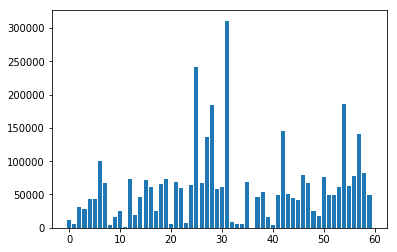

In [9]:
def bar_sale_shopid(data):
    shopidlist = sorted(Counter(data['shop_id']))
    print(shopidlist)
    sale_of_shopid_list = []
    for i in shopidlist:
        selecteddata = data[data.shop_id==i]
        sale_of_shopid_list.append(sum(selecteddata['item_cnt_day']))
    plt.bar(shopidlist, sale_of_shopid_list)
    return

bar_sale_shopid(train)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


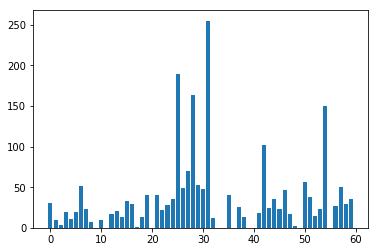

In [10]:
#sale shopid
def saleitem_shopid(data, itemid):
    shopidlist = sorted(Counter(data['shop_id']))
    print(shopidlist)
    sale_of_shopid_list = []
    '''
    for i in shopidlist:
        print('shop',i)
        selecteddata = data[data.shop_id==i]
        g = selecteddata.groupby('item_id')
        print(g['item_cnt_day'].sum())
    '''
    sale_of_item = []
    for i in shopidlist:
        selecteddata = data[(data.shop_id==i) & (data.item_id==itemid)]
        sale_of_item.append(sum(selecteddata['item_cnt_day']))
    plt.bar(shopidlist, sale_of_item)
    return

saleitem_shopid(train, 30)

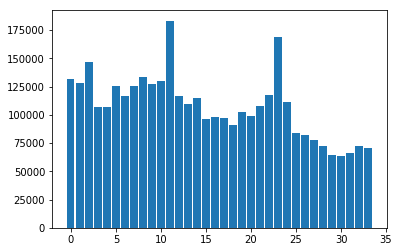

In [11]:
#month(x) item cnt day(y)
def bar_month_itemcntday(data):
    g = data.groupby('date_block_num')
    date_item = g['item_cnt_day'].sum()
    plt.bar(range(34), date_item)
    return

#Counter(train['date_block_num']) #34months
bar_month_itemcntday(train)

In [12]:
gp = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
X = np.array(list(map(list, gp.index.values)))
Y_train = gp.values
test['date_block_num'] = train['date_block_num'].max() + 1
X_test = test[['date_block_num', 'shop_id', 'item_id']].values

In [13]:
oh0 = OneHotEncoder().fit(X[:,0].reshape(-1, 1))
x0 = oh0.transform(X[:,0].reshape(-1, 1))
oh1 = OneHotEncoder().fit(X[:,1].reshape(-1, 1))
x1 = oh1.transform(X[:,1].reshape(-1, 1))
x1_t = oh1.transform(X_test[:,1].reshape(-1, 1))
X_train = np.concatenate((X[:, :1], x1.toarray(), X[:, 2:]), axis=1)
X_test = np.concatenate((X_test[:, :1], x1_t.toarray(), X_test[:, 2:]), axis=1)

In [14]:
# rfr = RandomForestRegressor().fit(X_train, Y_train.ravel())
linearRegression = LinearRegression().fit(X_train, Y_train)

In [23]:
knnRegression = neighbors.KNeighborsRegressor(n_neighbors=5).fit(X_train, Y_train)

In [24]:
rmse = np.sqrt(mean_squared_error(Y_train, knnRegression.predict(X_train)))
print(rmse)
# Y_test = linearRegression.predict(X_test)
# submission['item_cnt_month'] = Y_test
# submission.to_csv('submission.csv', index=False)

4.7441981891200795
